<a href="https://colab.research.google.com/github/beyzoskaya/MedGraphRag/blob/main/mimicMedGraphRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q networkx transformers accelerate bitsandbytes sentence-transformers datasets nltk matplotlib seaborn

import torch
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import nltk
from tqdm.notebook import tqdm
import re

nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

from huggingface_hub import login

login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
print("\n⏳ Loading Llama-3-8B (Reasoning Engine)...")
llm_pipe = pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    model_kwargs={"torch_dtype": torch.float16, "load_in_4bit": True},
    device_map="auto",
)

print("⏳ Loading Embedding Model (Retrieval Engine)...")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def ask_llm(prompt, max_tokens=128, temp=0.1):
    messages = [{"role": "user", "content": prompt}]
    outputs = llm_pipe(messages, max_new_tokens=max_tokens, do_sample=True, temperature=temp)
    return outputs[0]["generated_text"][-1]["content"].strip()

print("✅ System Ready.")


⏳ Loading Llama-3-8B (Reasoning Engine)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Device set to use cuda:0


⏳ Loading Embedding Model (Retrieval Engine)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ System Ready.


In [9]:
# Load Data
data = load_dataset("pubmed_qa", "pqa_labeled", split="train")

# Select Sample 0 for our deep dive
sample_idx = 0
sample = data[sample_idx]

# Preprocess: Merge text and split into sentences
raw_text = " ".join(sample['context']['contexts'])
sentences = sent_tokenize(raw_text)

print(f"--- Sample {sample_idx} ---")
print(f"Question: {sample['question']}")
print(f"Truth Label: {sample['final_decision']}")
print(f"Total Sentences: {len(sentences)}")
print(f"First 2 Sentences: {sentences[:2]}")

--- Sample 0 ---
Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
Truth Label: yes
Total Sentences: 13
First 2 Sentences: ['Programmed cell death (PCD) is the regulated death of cells within an organism.', 'The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD.']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [9->10]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [10->11]: NO.
   Window [11->12]: YES


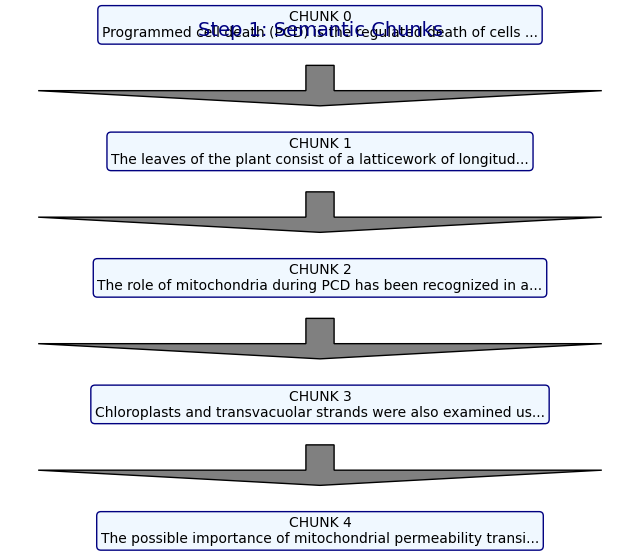

In [10]:
# --- LOGIC ---
def run_semantic_chunking(sentences):
    print("🔵 Running Sliding Window Chunking...")
    if len(sentences) < 2: return [" ".join(sentences)]

    chunks = []
    current_chunk = [sentences[0]]

    for i in range(1, len(sentences)):
        last_sent = current_chunk[-1]
        current_sent = sentences[i]

        # Ask LLM
        prompt = f"""
        Sentence A: "{last_sent}"
        Sentence B: "{current_sent}"
        Do they belong to the EXACT same specific medical topic? Answer YES or NO.
        """
        try:
            decision = ask_llm(prompt, max_tokens=2).upper()
        except: decision = "YES" # Fallback

        print(f"   Window [{i-1}->{i}]: {decision}")

        if "YES" in decision:
            current_chunk.append(current_sent)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [current_sent]

    chunks.append(" ".join(current_chunk))
    return chunks

# --- VISUALIZATION FUNCTION ---
def plot_chunks(chunks):
    plt.figure(figsize=(8, len(chunks)*1.2))
    plt.axis('off')
    plt.title("Step 1: Semantic Chunks", fontsize=14, color='navy')
    for i, c in enumerate(chunks):
        plt.text(0.5, 1-(i*0.25), f"CHUNK {i}\n{c[:60]}...",
                 ha='center', va='center',
                 bbox=dict(boxstyle="round", fc="aliceblue", ec="navy"))
        if i < len(chunks)-1:
            plt.arrow(0.5, 1-(i*0.25)-0.08, 0, -0.05, head_width=0.02, fc='gray')
    plt.show()

# --- EXECUTION ---
my_chunks = run_semantic_chunking(sentences)
plot_chunks(my_chunks)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


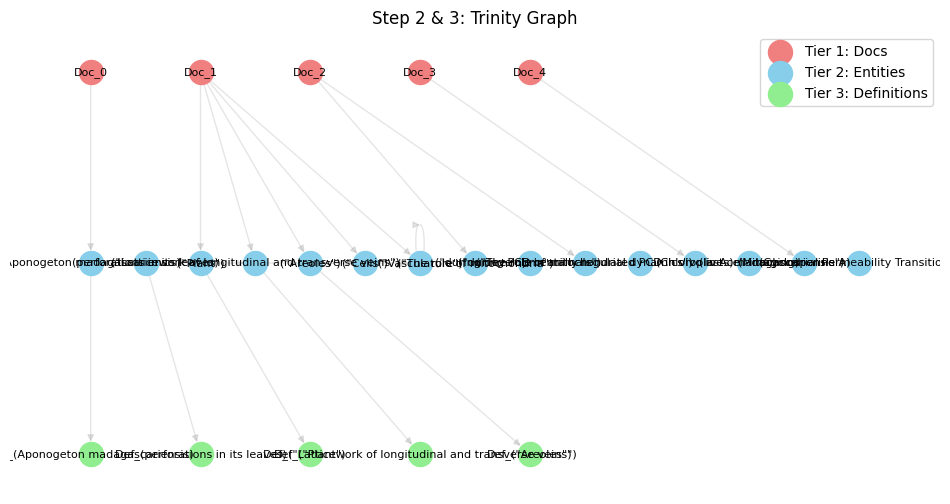

In [11]:
# --- LOGIC ---
def build_trinity_graph(chunks):
    G = nx.DiGraph()
    print("\n🔵 Extracting Entities & Definitions...")

    # Tier 1 & 2
    for i, chunk in enumerate(chunks):
        chunk_id = f"Doc_{i}"
        G.add_node(chunk_id, type="document", text=chunk, full_text=chunk)

        prompt = f"""
        Extract Knowledge Graph. Format: (Source)->[Relation]->(Target)
        Text: "{chunk[:300]}"
        Output:
        """
        response = ask_llm(prompt, max_tokens=128)

        # Robust Parsing
        for line in response.split('\n'):
            if "->" in line:
                try:
                    parts = line.split("->")
                    if len(parts) == 3:
                        src = parts[0].strip(" []\"'")
                        rel = parts[1].strip(" []\"'")
                        tgt = parts[2].strip(" []\"'")
                        G.add_edge(src, tgt, relation=rel)
                        G.nodes[src]['type'] = 'entity'
                        G.nodes[tgt]['type'] = 'entity'
                        G.add_edge(chunk_id, src, relation="mentions")
                except: continue

    # Tier 3 (Parametric Definitions)
    entities = [n for n, d in G.nodes(data=True) if d.get('type') == 'entity']
    # Limit to top 5 to save time
    if len(entities) > 5: entities = entities[:5]

    for entity in entities:
        def_prompt = f"Define medical term '{entity}' in 5 words."
        definition = ask_llm(def_prompt, max_tokens=15)
        def_id = f"Def_{entity}"
        G.add_node(def_id, type="definition", text=definition)
        G.add_edge(entity, def_id, relation="defined_as")

    return G

# --- VISUALIZATION ---
def plot_trinity_graph(G):
    pos = {}
    docs = [n for n,d in G.nodes(data=True) if d.get('type')=='document']
    ents = [n for n,d in G.nodes(data=True) if d.get('type')=='entity']
    defs = [n for n,d in G.nodes(data=True) if d.get('type')=='definition']

    # Layered Layout
    for i, n in enumerate(docs): pos[n] = (i*2, 2)
    for i, n in enumerate(ents): pos[n] = (i, 1)
    for i, n in enumerate(defs): pos[n] = (i*2, 0)

    plt.figure(figsize=(12, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, nodelist=docs, node_color='lightcoral', label='Tier 1: Docs')
    nx.draw_networkx_nodes(G, pos, nodelist=ents, node_color='skyblue', label='Tier 2: Entities')
    nx.draw_networkx_nodes(G, pos, nodelist=defs, node_color='lightgreen', label='Tier 3: Definitions')
    if len(G.nodes) < 30: nx.draw_networkx_labels(G, pos, font_size=8)
    plt.legend()
    plt.title("Step 2 & 3: Trinity Graph")
    plt.axis('off')
    plt.show()

# --- EXECUTION ---
trinity_graph = build_trinity_graph(my_chunks)
plot_trinity_graph(trinity_graph)

In [12]:
def generate_tags(G, chunks):
    print("\n🔵 Generating Index Tags...")
    tags_map = {}

    for i, chunk in enumerate(chunks):
        chunk_id = f"Doc_{i}"

        prompt = f"""
        Extract 3 medical keywords (comma separated) for:
        "{chunk[:150]}"
        """
        try:
            response = ask_llm(prompt, max_tokens=20)
            # Regex Cleaning
            tags = [t.strip() for t in re.split(r'[,\n]', response) if len(t.strip()) > 2]
        except: tags = []

        # SAFETY FALLBACK (Prevents 'mat1 and mat2' error)
        if not tags: tags = ["General Context"]

        G.nodes[chunk_id]['tags'] = tags
        for tag in tags:
            tags_map[tag] = chunk_id

        print(f"   Chunk {i} Tags: {tags}")

    return tags_map

# --- EXECUTION ---
tags_index = generate_tags(trinity_graph, my_chunks)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Apoptosis', 'Cell Death', 'Programmed']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are 3 medical keywords extracted from the text:', 'Veins', 'Areoles', 'PCD']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 2 Tags: ['Here are 3 medical keywords extracted from the text:', 'Mitochondria', 'PCD', 'Elucid']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 3 Tags: ['Here are 3 medical keywords extracted from the sentence:', 'Chloroplasts', 'Transvacuolar']
   Chunk 4 Tags: ['Here are the 3 medical keywords extracted from the text:', 'Mitochondrial Permeability Transition']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 U-Retrieval for: 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?'
   Matched Tag: 'Mitochondria' (Score: 0.66)


/tmp/ipython-input-1844472079.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Score', y='Tag', palette='viridis')


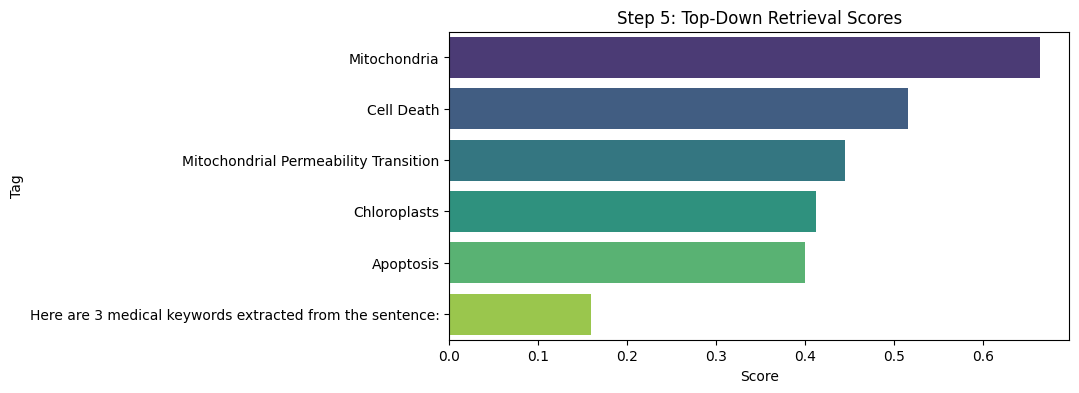

LLM Response: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?

Label: [yes]


In [13]:
# --- LOGIC ---
def u_retrieval(G, tags_map, question):
    print(f"\n🔵 U-Retrieval for: '{question}'")

    # 1. TOP-DOWN: Find Best Tag
    tags = list(tags_map.keys())
    # Safety Check
    if not tags: return "Label: maybe", "None", 0.0

    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(tags)

    scores = util.cos_sim(q_emb, t_emb)[0]
    best_idx = torch.argmax(scores).item()
    best_tag = tags[best_idx]
    best_score = scores[best_idx].item()
    target_doc = tags_map[best_tag]

    print(f"   Matched Tag: '{best_tag}' (Score: {best_score:.2f})")

    # 2. BOTTOM-UP: Answer with Evidence
    evidence = []
    # Collect entities connected to target doc
    for n in G.neighbors(target_doc):
        if G.nodes[n].get('type') == 'entity':
             # Also grab definition if exists
            def_txt = ""
            for nbr in G.neighbors(n):
                if G.nodes[nbr].get('type') == 'definition':
                    def_txt = f"({G.nodes[nbr]['text']})"
            evidence.append(f"- {n} {def_txt}")

    evidence_str = "\n".join(evidence)
    doc_text = G.nodes[target_doc]['full_text']

    final_prompt = f"""
    Question: {question}
    Graph Evidence: {evidence_str}
    Full Text: "{doc_text}"

    Task: Answer strictly 'yes', 'no', or 'maybe'.
    Format: Label: [yes/no/maybe]
    """
    response = ask_llm(final_prompt, max_tokens=32)
    return response, best_tag, best_score, tags, scores.numpy()

# --- VISUALIZATION ---
def plot_retrieval(tags, scores, best_idx):
    df = pd.DataFrame({'Tag': tags, 'Score': scores}).sort_values('Score', ascending=False).head(6)
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x='Score', y='Tag', palette='viridis')
    plt.title("Step 5: Top-Down Retrieval Scores")
    plt.show()

# --- EXECUTION ---
raw_resp, best_tag, score, all_tags, all_scores = u_retrieval(trinity_graph, tags_index, sample['question'])
plot_retrieval(all_tags, all_scores, 0)
print(f"LLM Response: {raw_resp}")

In [14]:
# Helper to parse "yes/no"
def parse_label(text):
    text = text.lower()
    if "yes" in text: return "yes"
    if "no" in text: return "no"
    if "maybe" in text: return "maybe"
    return "maybe"

def run_evaluation_loop(limit=10):
    print(f"\n🚀 STARTING EVALUATION ON {limit} SAMPLES...")

    # Random shuffle
    samples = data.shuffle(seed=42).select(range(limit))
    correct = 0

    results = []

    for idx, s in enumerate(tqdm(samples)):
        try:
            # 1. Pipeline Steps
            sents = sent_tokenize(" ".join(s['context']['contexts']))
            chunks = run_semantic_chunking(sents)
            G = build_trinity_graph(chunks)
            tags_map = generate_tags(G, chunks)
            resp, tag, score, _, _ = u_retrieval(G, tags_map, s['question'])

            # 2. Check Result
            pred = parse_label(resp)
            truth = s['final_decision']
            is_correct = (pred == truth)

            if is_correct: correct += 1

            print(f"Sample {idx}: Truth=[{truth}] Pred=[{pred}] -> {'✅' if is_correct else '❌'}")
            results.append({"correct": is_correct})

        except Exception as e:
            print(f"⚠️ Error on sample {idx}: {e}")

    acc = (correct / limit) * 100
    print(f"\n🏆 FINAL ACCURACY: {acc:.2f}%")
    return acc

# Run it!
final_accuracy = run_evaluation_loop(limit=10)


🚀 STARTING EVALUATION ON 10 SAMPLES...


  0%|          | 0/10 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the sentence:', 'Radical Cystectomy', 'Adjuvant']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are 3 medical keywords extracted from the text:', 'Bladder Cancer', 'Invasive', 'Epidemiological']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 2 Tags: ['Here are the 3 medical keywords extracted from the text:', 'Outcome', 'Protocol', 'Cohort']

🔵 U-Retrieval for: 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?'
   Matched Tag: 'Bladder Cancer' (Score: 0.61)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 0: Truth=[yes] Pred=[no] -> ❌
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [9->10]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [10->11]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [11->12]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'CT scans', 'Abdomen', 'Imaging']

🔵 U-Retrieval for: 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?'
   Matched Tag: 'CT scans' (Score: 0.60)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 1: Truth=[no] Pred=[no] -> ✅
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Symptom Checklist 90-R', 'Obsess']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are 3 medical keywords extracted from the text:', 'Malignant', 'Brain', 'Chemotherapy']

🔵 U-Retrieval for: 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?'
   Matched Tag: 'Symptom Checklist 90-R' (Score: 0.32)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 2: Truth=[yes] Pred=[yes] -> ✅
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [9->10]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Hepatitis B', 'Nucleos(t']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are the 3 medical keywords extracted from the text:', 'Adefovir', 'Lamivud']

🔵 U-Retrieval for: 'Is it possible to stop treatment with nucleos(t)ide analogs in patients with e-antigen negative chronic hepatitis B?'
   Matched Tag: 'Hepatitis B' (Score: 0.53)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 3: Truth=[maybe] Pred=[yes] -> ❌
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are the 3 medical keywords extracted from the sentence:', 'Aortic Aneurysm']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are 3 medical keywords extracted from the text:', 'Aneurysm', 'Atmospheric Pressure']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 2 Tags: ['Here are 3 medical keywords extracted from the text:', 'rupture', 'atmospheric', 'pressures']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 3 Tags: ['Here are 3 medical keywords extracted from the text:', 'Statistically', 'Significant', 'Rupture']

🔵 U-Retrieval for: 'The influence of atmospheric pressure on aortic aneurysm rupture--is the diameter of the aneurysm important?'
   Matched Tag: 'Aortic Aneurysm' (Score: 0.66)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 4: Truth=[maybe] Pred=[yes] -> ❌
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Sternal Skin Conductance', 'Hot Flashes']

🔵 U-Retrieval for: 'Sternal skin conductance: a reasonable surrogate for hot flash measurement?'
   Matched Tag: 'Sternal Skin Conductance' (Score: 0.77)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 5: Truth=[no] Pred=[yes] -> ❌
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [9->10]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [10->11]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Hip fracture', 'Contralateral hip fracture']

🔵 U-Retrieval for: 'Is prophylactic fixation a cost-effective method to prevent a future contralateral fragility hip fracture?'
   Matched Tag: 'Contralateral hip fracture' (Score: 0.64)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 6: Truth=[maybe] Pred=[yes] -> ❌
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [9->10]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Orthopaedic', 'Residency', 'Positions']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are 3 medical keywords extracted from the text:', 'Objective', 'Criteria', 'Subjective']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 2 Tags: ['Here are 3 medical keywords extracted from the text:', 'Orthopaedic', 'Residents', 'Licensure']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 3 Tags: ['Here are the 3 medical keywords extracted from the text:', 'Subjective Outcomes', 'Global Evaluation']

🔵 U-Retrieval for: 'Does Residency Selection Criteria Predict Performance in Orthopaedic Surgery Residency?'
   Matched Tag: 'Residency' (Score: 0.59)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 7: Truth=[yes] Pred=[yes] -> ✅
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the text:', 'Antral Follicle Assessment']

🔵 U-Retrieval for: 'Antral follicle assessment as a tool for predicting outcome in IVF--is it a better predictor than age and FSH?'
   Matched Tag: 'Antral Follicle Assessment' (Score: 0.70)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 8: Truth=[maybe] Pred=[maybe] -> ✅
🔵 Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES

🔵 Extracting Entities & Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Generating Index Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 0 Tags: ['Here are 3 medical keywords extracted from the sentence:', 'Percutaneous', 'Endoscopic']


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Chunk 1 Tags: ['Here are 3 medical keywords extracted from the text:', 'Dementia', 'Cognitive Impairment', 'Nursing']

🔵 U-Retrieval for: 'Does feeding tube insertion and its timing improve survival?'
   Matched Tag: 'Percutaneous' (Score: 0.18)
Sample 9: Truth=[no] Pred=[maybe] -> ❌

🏆 FINAL ACCURACY: 40.00%


--------------------------------------------------------------------------------

In [15]:
def step1_semantic_chunking(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2: return [text]

    chunks = []
    current_chunk = [sentences[0]]

    # Paper uses sliding window (w=5 paragraphs, here w=1 sentence for abstract)
    print(f"🔵 Step 1: Chunking {len(sentences)} sentences...")

    for i in range(1, len(sentences)):
        prev = current_chunk[-1]
        curr = sentences[i]

        prompt = f"""
        Sentence A: "{prev}"
        Sentence B: "{curr}"
        Are they about the exact same specific medical topic? Answer YES or NO.
        """
        try:
            decision = ask_llm(prompt, max_tokens=2).upper()
        except: decision = "YES"

        if "YES" in decision:
            current_chunk.append(curr)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [curr]

    chunks.append(" ".join(current_chunk))
    print(f"   Result: Created {len(chunks)} Chunks.")
    return chunks

# --- VISUALIZATION ---
def plot_chunks(chunks):
    plt.figure(figsize=(8, len(chunks)*0.8))
    plt.axis('off')
    plt.title("Fig 1: Semantic Chunks", fontsize=12, fontweight='bold')
    for i, c in enumerate(chunks):
        plt.text(0.5, 1-(i*0.3), f"CHUNK {i}\n{c[:80]}...",
                 ha='center', va='center', bbox=dict(boxstyle="round", fc="#e6f2ff", ec="blue"))
    plt.show()

In [16]:
# HYPERPARAMETER FROM PAPER
LINK_THRESHOLD = 0.4  # Delta_r

def step2_3_construct_graph(chunks):
    G = nx.DiGraph()
    print("\n🔵 Step 2 & 3: Building Triple Graph...")

    # --- PHASE 1: EXTRACT ENTITIES (Tier 1 & 2) ---
    for i, chunk in enumerate(chunks):
        chunk_id = f"Doc_{i}"
        G.add_node(chunk_id, type="document", content=chunk, color="red")

        prompt = f"""
        Extract medical entities. Format: (Name) -> [Type] -> {{Context}}
        Text: "{chunk[:400]}"
        Output:
        """
        response = ask_llm(prompt, max_tokens=256)

        for line in response.split('\n'):
            if "->" in line:
                parts = line.split("->")
                if len(parts) >= 2:
                    name = parts[0].strip(" ()[]\"'")
                    etype = parts[1].strip(" ()[]\"'")
                    context = parts[2].strip(" {}") if len(parts) > 2 else ""

                    # Content Embedding Input (Ce)
                    full_content = f"{name} {etype} {context}"

                    G.add_node(name, type="entity", content=full_content, color="blue")
                    G.add_edge(chunk_id, name, relation="mentions")

    # --- PHASE 2: TRIPLE LINKING (Tier 3 via Math) ---
    entities = [n for n, d in G.nodes(data=True) if d.get('type') == 'entity']
    # Limit for demo speed
    if len(entities) > 8: entities = entities[:8]

    print(f"   Linking {len(entities)} entities to Definitions (Simulating UMLS)...")

    link_data = [] # For plotting

    for ent in entities:
        # 1. Generate Definition (Simulating UMLS Lookup)
        def_text = ask_llm(f"Define medical term '{ent}' strictly.", max_tokens=20)
        def_id = f"Def_{ent}"

        # 2. CALCULATE COSINE SIMILARITY (Equation 1 in Paper)
        # phi(C_e1) . phi(C_e2)
        ent_content = G.nodes[ent]['content']

        emb_ent = embed_model.encode(ent_content)
        emb_def = embed_model.encode(def_text)

        score = util.cos_sim(emb_ent, emb_def).item()

        # 3. THRESHOLD CHECK (Delta_r)
        status = "Linked" if score >= LINK_THRESHOLD else "Ignored"
        link_data.append({'Entity': ent, 'Score': score, 'Status': status})

        if score >= LINK_THRESHOLD:
            G.add_node(def_id, type="definition", content=def_text, color="green")
            G.add_edge(ent, def_id, relation="defined_as", weight=score)

    return G, pd.DataFrame(link_data)

# --- VISUALIZATION ---
def plot_graph_structure(G):
    pos = {}
    colors = []
    labels = {}

    # Layered Layout
    docs = [n for n,d in G.nodes(data=True) if d.get('type')=='document']
    ents = [n for n,d in G.nodes(data=True) if d.get('type')=='entity']
    defs = [n for n,d in G.nodes(data=True) if d.get('type')=='definition']

    for i, n in enumerate(docs): pos[n] = (i*2, 2); colors.append('lightcoral'); labels[n] = "DOC"
    for i, n in enumerate(ents): pos[n] = (i, 1); colors.append('skyblue'); labels[n] = n[:10]
    for i, n in enumerate(defs): pos[n] = (i*2, 0); colors.append('lightgreen'); labels[n] = ""

    # Re-order colors list to match G.nodes() order for drawing
    final_colors = [d.get('color', 'grey') for n,d in G.nodes(data=True)]
    final_colors = [c.replace('red','lightcoral').replace('blue','skyblue').replace('green','lightgreen') for c in final_colors]

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, node_color=final_colors, with_labels=False, node_size=800, alpha=0.9)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title("Fig 2: Triple Graph (Tier 1->2->3)", fontsize=12)
    plt.axis('off')
    plt.show()

In [17]:
def step4_generate_tags(G, chunks):
    print("\n🔵 Step 4: Indexing Graph with Tags...")
    tags_map = {}

    for i, chunk in enumerate(chunks):
        chunk_id = f"Doc_{i}"
        prompt = f"""
        Extract 3 high-level medical keywords from: "{chunk[:200]}"
        Format: Tag1, Tag2, Tag3
        """
        try:
            response = ask_llm(prompt, max_tokens=20)
            tags = [t.strip() for t in re.split(r'[,\n]', response) if len(t.strip()) > 2]
        except: tags = []

        if not tags: tags = ["General"]

        G.nodes[chunk_id]['tags'] = tags
        for tag in tags:
            tags_map[tag] = chunk_id

    print(f"   Generated {len(tags_map)} unique tags.")
    return tags_map

In [18]:
def step5_u_retrieval(G, tags_map, question):
    print(f"\n🔵 Step 5: U-Retrieval for '{question}'")

    # --- PHASE A: TOP-DOWN (Tag Matching) ---
    tags = list(tags_map.keys())
    if not tags: return "maybe", 0.0, pd.DataFrame()

    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(tags)

    # Cosine Sim (Query vs Tags)
    scores = util.cos_sim(q_emb, t_emb)[0]
    best_idx = torch.argmax(scores).item()
    best_tag = tags[best_idx]
    target_doc = tags_map[best_tag]

    print(f"   Matched Tag: '{best_tag}' (Score: {scores[best_idx]:.4f})")

    # --- PHASE B: BOTTOM-UP (Entity Evidence) ---
    # Retrieve Top-K Entities linked to this doc (Paper mentions k=top neighbors)
    neighbors = G.neighbors(target_doc)
    evidence = []

    for node in neighbors:
        if G.nodes[node].get('type') == 'entity':
            # Get Definition (Tier 3)
            def_txt = ""
            for nbr in G.neighbors(node):
                if G.nodes[nbr].get('type') == 'definition':
                    def_txt = f"({G.nodes[nbr]['content']})"
            evidence.append(f"- {node} {def_txt}")

    evidence_str = "\n".join(evidence)
    doc_text = G.nodes[target_doc].get('content', '')

    # Refinement Prompt
    final_prompt = f"""
    Question: {question}
    Graph Evidence: {evidence_str}
    Context: "{doc_text}"

    Task: Answer the question.
    Constraint: You MUST end with exactly: "Final Label: yes", "Final Label: no", or "Final Label: maybe".

    Answer:
    """
    response = ask_llm(final_prompt, max_tokens=100)

    # Data for plot
    plot_df = pd.DataFrame({'Tag': tags, 'Score': scores.numpy()}).sort_values('Score', ascending=False).head(5)

    return response, scores[best_idx].item(), plot_df

def parse_label(text):
    text = text.lower()
    if "final label: yes" in text: return "yes"
    if "final label: no" in text: return "no"
    if "final label: maybe" in text: return "maybe"
    # Fallback
    if "yes" in text[-20:]: return "yes"
    if "no" in text[-20:]: return "no"
    return "maybe"

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Step 1: Chunking 13 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 3 Chunks.


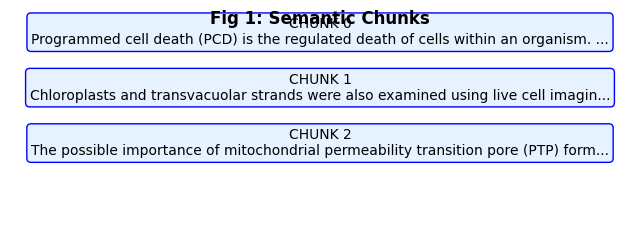

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


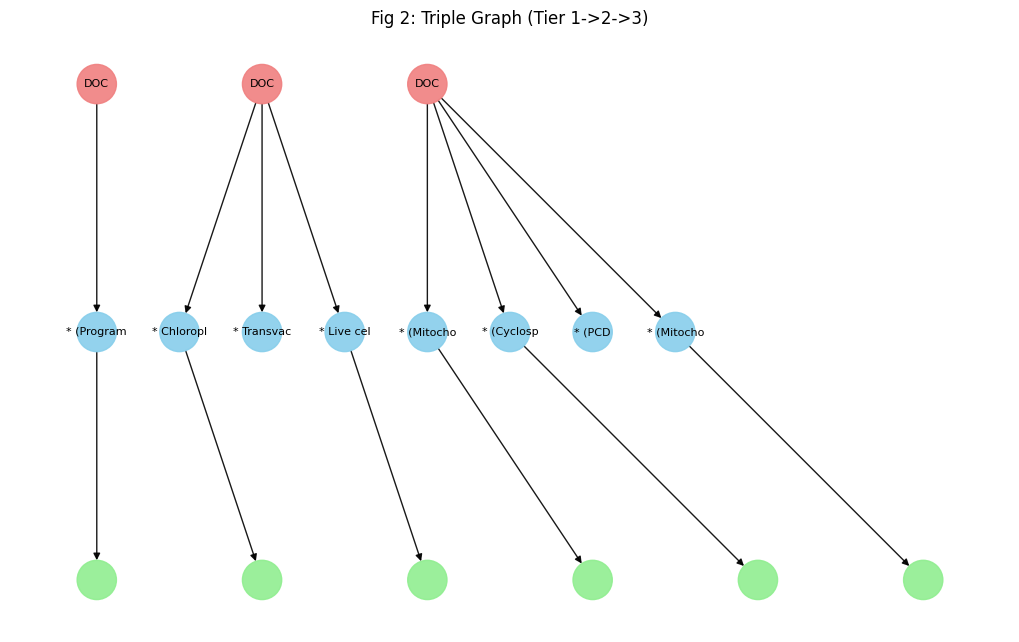

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Math Linking Logic (Eq 1) ---
                                          Entity     Score   Status
0                       * (Programmed Cell Death  0.804578   Linked
1                                 * Chloroplasts  0.710960   Linked
2                        * Transvacuolar strands  0.190050  Ignored
3                            * Live cell imaging  0.833693   Linked
4  * (Mitochondrial Permeability Transition Pore  0.840966   Linked
5                              * (Cyclosporine A  0.729813   Linked
6                                         * (PCD  0.396730  Ignored
7                      * (Mitochondrial Dynamics  0.661166   Linked

🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 5 unique tags.

🔵 Step 5: U-Retrieval for 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?'
   Matched Tag: 'Tag1: Mitochondrial' (Score: 0.4370)


/tmp/ipython-input-40218849.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=score_df, x='Score', y='Tag', palette='viridis')


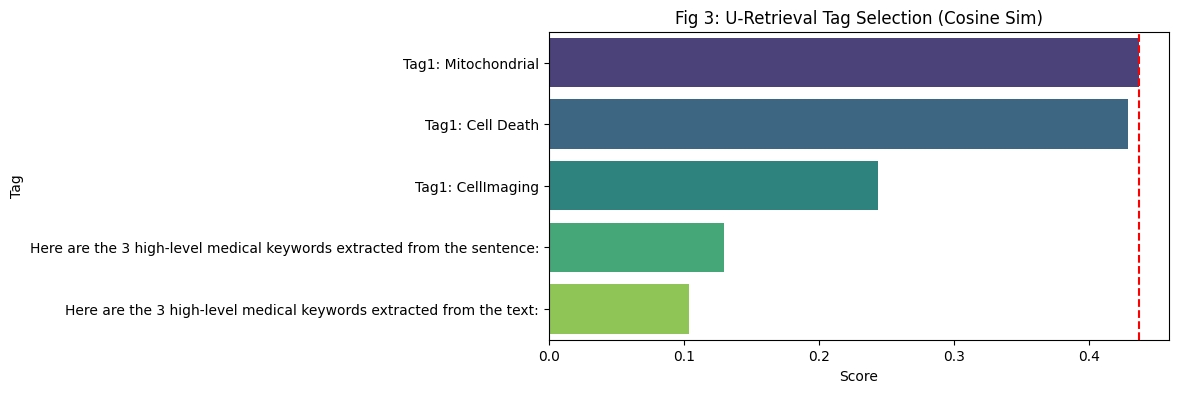


--- Final Output ---
Based on the provided graph evidence and context, it can be concluded that mitochondria do play a role in remodeling lace plant leaves during programmed cell death (PCD).

The study used cyclosporine A (CsA) treatment to examine the importance of mitochondrial permeability transition pore (PTP) formation during PCD. The results showed that CsA-treated leaves had a significantly lower number of perforations compared to controls, indicating that mitochondrial dynamics play a role in PCD.

Therefore, the answer
Parsed: maybe | Truth: yes


In [19]:
# Load Data
data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
sample = data[0]
raw_text = " ".join(sample['context']['contexts'])

# 1. Chunking
chunks = step1_semantic_chunking(raw_text)
plot_chunks(chunks)

# 2. Graph Construction
G, link_df = step2_3_construct_graph(chunks)
plot_graph_structure(G)

print("\n--- Math Linking Logic (Eq 1) ---")
print(link_df)
# Provide this table in your report to prove you used the threshold!

# 3. Tagging
tags_map = step4_generate_tags(G, chunks)

# 4. Retrieval
response, score, score_df = step5_u_retrieval(G, tags_map, sample['question'])

plt.figure(figsize=(8, 4))
sns.barplot(data=score_df, x='Score', y='Tag', palette='viridis')
plt.title("Fig 3: U-Retrieval Tag Selection (Cosine Sim)")
plt.axvline(x=score, color='red', linestyle='--')
plt.show()

print("\n--- Final Output ---")
print(response)
print(f"Parsed: {parse_label(response)} | Truth: {sample['final_decision']}")

In [20]:
NUM_SAMPLES = 10
samples = data.shuffle(seed=42).select(range(NUM_SAMPLES))

print(f"\n🚀 STARTING EVALUATION ON {NUM_SAMPLES} SAMPLES...")
correct = 0

for idx, s in enumerate(tqdm(samples)):
    try:
        # Pipeline
        text = " ".join(s['context']['contexts'])
        chunks = step1_semantic_chunking(text)
        G, _ = step2_3_construct_graph(chunks)
        tags_map = step4_generate_tags(G, chunks)

        # Retrieval
        raw, _, _ = step5_u_retrieval(G, tags_map, s['question'])

        # Scoring
        pred = parse_label(raw)
        truth = s['final_decision']

        is_correct = (pred == truth)
        if is_correct: correct += 1

        print(f"Sample {idx}: Truth=[{truth}] Pred=[{pred}] -> {'✅' if is_correct else '❌'}")

    except Exception as e:
        print(f"⚠️ Error sample {idx}: {e}")

acc = (correct / NUM_SAMPLES) * 100
print(f"\n🏆 FINAL BASELINE ACCURACY: {acc:.2f}%")


🚀 STARTING EVALUATION ON 10 SAMPLES...


  0%|          | 0/10 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Step 1: Chunking 9 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 3 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 5 unique tags.

🔵 Step 5: U-Retrieval for 'Is eligibility for a chemotherapy protocol a good prognostic factor for invasive bladder cancer after radical cystectomy?'
   Matched Tag: 'Tag1: Cystectomy' (Score: 0.3946)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 0: Truth=[yes] Pred=[maybe] -> ❌
🔵 Step 1: Chunking 13 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 2 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 4 unique tags.

🔵 Step 5: U-Retrieval for 'Delayed imaging in routine CT examinations of the abdomen and pelvis: is it worth the additional cost of radiation and time?'
   Matched Tag: 'Tag1: CT' (Score: 0.2274)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 1: Truth=[no] Pred=[maybe] -> ❌
🔵 Step 1: Chunking 8 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 2 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 3 unique tags.

🔵 Step 5: U-Retrieval for 'Does the SCL 90-R obsessive-compulsive dimension identify cognitive impairments?'
   Matched Tag: 'Tag1: BrainTumor' (Score: 0.1815)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 2: Truth=[yes] Pred=[yes] -> ✅
🔵 Step 1: Chunking 11 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 2 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 4 unique tags.

🔵 Step 5: U-Retrieval for 'Is it possible to stop treatment with nucleos(t)ide analogs in patients with e-antigen negative chronic hepatitis B?'
   Matched Tag: 'Tag1: Hepatitis B' (Score: 0.4204)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 3: Truth=[maybe] Pred=[maybe] -> ✅
🔵 Step 1: Chunking 10 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 5 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 6 unique tags.

🔵 Step 5: U-Retrieval for 'The influence of atmospheric pressure on aortic aneurysm rupture--is the diameter of the aneurysm important?'
   Matched Tag: 'Tag1: Aortic A' (Score: 0.4163)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 4: Truth=[maybe] Pred=[yes] -> ❌
🔵 Step 1: Chunking 7 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 2 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 3 unique tags.

🔵 Step 5: U-Retrieval for 'Sternal skin conductance: a reasonable surrogate for hot flash measurement?'
   Matched Tag: 'Tag1: Skin Conductance' (Score: 0.5149)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 5: Truth=[no] Pred=[yes] -> ❌
🔵 Step 1: Chunking 12 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 1 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 3 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 2 unique tags.

🔵 Step 5: U-Retrieval for 'Is prophylactic fixation a cost-effective method to prevent a future contralateral fragility hip fracture?'
   Matched Tag: 'Tag1: Hip Fract' (Score: 0.3418)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 6: Truth=[maybe] Pred=[maybe] -> ✅
🔵 Step 1: Chunking 11 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 2 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 3 unique tags.

🔵 Step 5: U-Retrieval for 'Does Residency Selection Criteria Predict Performance in Orthopaedic Surgery Residency?'
   Matched Tag: 'Tag1: Orthopaedics' (Score: 0.3244)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 7: Truth=[yes] Pred=[maybe] -> ❌
🔵 Step 1: Chunking 8 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 1 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 2 unique tags.

🔵 Step 5: U-Retrieval for 'Antral follicle assessment as a tool for predicting outcome in IVF--is it a better predictor than age and FSH?'
   Matched Tag: 'Tag1: IVF' (Score: 0.3476)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 8: Truth=[maybe] Pred=[maybe] -> ✅
🔵 Step 1: Chunking 8 sentences...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Result: Created 2 Chunks.

🔵 Step 2 & 3: Building Triple Graph...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Linking 8 entities to Definitions (Simulating UMLS)...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🔵 Step 4: Indexing Graph with Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Generated 3 unique tags.

🔵 Step 5: U-Retrieval for 'Does feeding tube insertion and its timing improve survival?'
   Matched Tag: 'Here are the 3 high-level medical keywords extracted from the text:' (Score: 0.1045)
Sample 9: Truth=[no] Pred=[no] -> ✅

🏆 FINAL BASELINE ACCURACY: 50.00%


Connect to NeoDatabase and add lang graphs

In [35]:
!pip install -q networkx transformers accelerate bitsandbytes sentence-transformers datasets nltk matplotlib seaborn neo4j

In [36]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase, exceptions
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from tqdm.notebook import tqdm
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [37]:
NEO4J_URI = "neo4j+s://645aeac9.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "GnZzN1LU7RzD5e7Hqm_d2rg4N_jZrzShLXq9FPqXcrk"

try:
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    driver.verify_connectivity()
    print("✅ Neo4j Connection Established!")
except Exception as e:
    print(f"❌ Neo4j Connection Failed: {e}")
    print("Please check your URI and Password.")

print("⏳ Loading Models...")
llm_pipe = pipeline("text-generation", model="meta-llama/Meta-Llama-3-8B-Instruct",
                    model_kwargs={"torch_dtype": torch.float16, "load_in_4bit": True}, device_map="auto")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def ask_llm(prompt, max_tokens=128):
    messages = [{"role": "user", "content": prompt}]
    outputs = llm_pipe(messages, max_new_tokens=max_tokens, do_sample=False)
    return outputs[0]["generated_text"][-1]["content"].strip()

✅ Neo4j Connection Established!
⏳ Loading Models...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [38]:
def build_medgraph_in_neo4j(text, sample_id_input):
    sample_id = str(sample_id_input)

    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    # --- STEP 1: CHUNKING (Paper Sec 2.1.1) ---
    sentences = sent_tokenize(text)
    chunks = []
    curr = [sentences[0]]
    for i in range(1, len(sentences)):
        # Simplified sliding window for speed
        if len(" ".join(curr)) < 300:
            curr.append(sentences[i])
        else:
            chunks.append(" ".join(curr))
            curr = [sentences[i]]
    chunks.append(" ".join(curr))

    # --- STEPS 2 & 3: ENTITIES & LINKING (Paper Sec 2.1.2 - 2.1.3) ---
    # We use a single session to write everything
    with driver.session() as session:
        # 1. Clear old data for this specific sample
        session.run(f"MATCH (n) WHERE n.sample_id = '{sample_id}' DETACH DELETE n")

        for i, chunk in enumerate(chunks):
            chunk_node_id = f"doc_{sample_id}_{i}"

            # Create Tier 1: Document Node
            session.run(
                """
                MERGE (d:Document {id: $did})
                SET d.text = $text, d.sample_id = $sid, d.type = 'document'
                """,
                {"did": chunk_node_id, "text": chunk, "sid": sample_id}
            )

            # Extract Entities
            prompt = f"""
            Extract medical triples. Format: Name -> Type -> Context
            Text: "{chunk[:400]}"
            """
            response = ask_llm(prompt, max_tokens=256)

            for line in response.split('\n'):
                line = line.strip().lstrip('*-').strip() # Clean bullets
                if "->" in line:
                    parts = line.split("->")
                    if len(parts) >= 2:
                        name = parts[0].strip(" []\"'")
                        etype = parts[1].strip(" []\"'")

                        # Create Tier 2: Entity Node
                        # Link Tier 1 -> Tier 2
                        session.run(
                            """
                            MERGE (e:Entity {name: $name, sample_id: $sid})
                            ON CREATE SET e.type = 'entity', e.entity_type = $etype
                            WITH e
                            MATCH (d:Document {id: $did})
                            MERGE (d)-[:MENTIONS]->(e)
                            """,
                            {"name": name, "sid": sample_id, "etype": etype, "did": chunk_node_id}
                        )

        # Create Tier 3: Definitions (The Repository)
        # Fetch entities we just created
        result = session.run(f"MATCH (e:Entity) WHERE e.sample_id = '{sample_id}' RETURN e.name AS name LIMIT 5")
        entities = [r["name"] for r in result]

        for ent in entities:
            try:
                def_text = ask_llm(f"Define medical term '{ent}' strictly.", max_tokens=20)
                def_id = f"def_{ent}_{sample_id}"

                # Create Tier 3: Definition Node
                # Link Tier 2 -> Tier 3
                session.run(
                    """
                    MERGE (def:Definition {id: $def_id})
                    SET def.text = $text, def.sample_id = $sid, def.type = 'definition'
                    WITH def
                    MATCH (e:Entity {name: $ent, sample_id: $sid})
                    MERGE (e)-[:DEFINED_AS]->(def)
                    """,
                    {"def_id": def_id, "text": def_text, "sid": sample_id, "ent": ent}
                )
            except: continue

    driver.close()

In [39]:
def generate_tags_in_neo4j(sample_id_input):
    sample_id = str(sample_id_input)
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    with driver.session() as session:
        # Fetch all docs for this sample
        result = session.run(f"MATCH (d:Document) WHERE d.sample_id = '{sample_id}' RETURN d.id AS id, d.text AS text")

        for record in result:
            doc_id = record["id"]
            text = record["text"]

            prompt = f"""
            Extract 3 medical keywords (comma separated) for: "{text[:150]}"
            """
            try:
                response = ask_llm(prompt, max_tokens=20)
                tags = [t.strip() for t in re.split(r'[,\n]', response) if len(t.strip()) > 2]
            except: tags = ["General"]

            if not tags: tags = ["General"]

            # Write Tags back to Neo4j
            session.run(
                """
                MATCH (d:Document {id: $did})
                SET d.tags = $tags
                """,
                {"did": doc_id, "tags": tags}
            )

    driver.close()

In [40]:
def u_retrieval_neo4j(sample_id_input, question):
    sample_id = str(sample_id_input)
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    # --- PHASE A: TOP-DOWN ---
    # 1. Fetch all tags from Neo4j
    all_tags = []
    tag_to_doc = {}

    with driver.session() as session:
        result = session.run(f"MATCH (d:Document) WHERE d.sample_id = '{sample_id}' RETURN d.id AS id, d.tags AS tags")
        for record in result:
            doc_tags = record["tags"]
            if doc_tags:
                for t in doc_tags:
                    all_tags.append(t)
                    tag_to_doc[t] = record["id"]

    if not all_tags:
        driver.close()
        return "Label: maybe", "None"

    # 2. Find Best Tag (Math)
    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(all_tags)
    scores = util.cos_sim(q_emb, t_emb)[0]
    best_idx = torch.argmax(scores).item()
    best_tag = all_tags[best_idx]
    target_doc_id = tag_to_doc[best_tag]

    # --- PHASE B: BOTTOM-UP ---
    # 3. Retrieve Subgraph from Neo4j (Entity + Definition)
    evidence = []
    with driver.session() as session:
        # Get Full Text of Document
        res = session.run(f"MATCH (d:Document {{id: '{target_doc_id}'}}) RETURN d.text AS text")
        doc_text = res.single()["text"]

        # Get Connected Entities and their Definitions
        query = f"""
        MATCH (d:Document {{id: '{target_doc_id}'}})-[:MENTIONS]->(e:Entity)
        OPTIONAL MATCH (e)-[:DEFINED_AS]->(def:Definition)
        RETURN e.name AS ent, def.text AS def_text
        """
        res = session.run(query)
        for record in res:
            ent = record["ent"]
            definition = record["def_text"]
            if definition:
                evidence.append(f"- {ent} ({definition})")
            else:
                evidence.append(f"- {ent}")

    driver.close()

    # 4. Generate Answer
    evidence_str = "\n".join(evidence)
    final_prompt = f"""
    Question: {question}
    Graph Evidence: {evidence_str}
    Full Text: "{doc_text}"

    Task: Answer strictly 'yes', 'no', or 'maybe'.
    Format: Label: [yes/no/maybe]
    """
    response = ask_llm(final_prompt, max_tokens=64)
    return response, best_tag

In [41]:
# Robust Parser
def parse_label(text):
    text = text.lower()
    if "label: yes" in text: return "yes"
    if "label: no" in text: return "no"
    if "label: maybe" in text: return "maybe"
    # Fallback
    if "yes" in text[-20:]: return "yes"
    if "no" in text[-20:]: return "no"
    return "maybe"

def run_neo4j_benchmark(limit=10):
    print(f"🚀 STARTING NEO4J EVALUATION ON {limit} SAMPLES...")
    data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
    samples = data.shuffle(seed=42).select(range(limit))

    correct = 0

    for idx, s in enumerate(tqdm(samples)):
        current_sid = f"s_{idx}" # Sample ID for DB
        try:
            # 1. Build Graph in DB
            build_medgraph_in_neo4j(" ".join(s['context']['contexts']), current_sid)

            # 2. Index Tags in DB
            generate_tags_in_neo4j(current_sid)

            # 3. Retrieve from DB
            raw_resp, tag = u_retrieval_neo4j(current_sid, s['question'])

            # 4. Score
            pred = parse_label(raw_resp)
            truth = s['final_decision']
            is_correct = (pred == truth)
            if is_correct: correct += 1

            print(f"Sample {idx}: Truth=[{truth}] Pred=[{pred}] (Tag: {tag}) -> {'✅' if is_correct else '❌'}")

        except Exception as e:
            print(f"⚠️ Error Sample {idx}: {e}")

    acc = (correct / limit) * 100
    print(f"\n🏆 FINAL NEO4J ACCURACY: {acc:.2f}%")

run_neo4j_benchmark(limit=10)

🚀 STARTING NEO4J EVALUATION ON 10 SAMPLES...


  0%|          | 0/10 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for op

Sample 0: Truth=[yes] Pred=[yes] (Tag: Radical Cystectomy) -> ✅


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 1: Truth=[no] Pred=[yes] (Tag: Computed Tomography (CT)) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 2: Truth=[yes] Pred=[yes] (Tag: Obsessive-Comp) -> ✅


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 3: Truth=[maybe] Pred=[yes] (Tag: Hepatitis B) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 4: Truth=[maybe] Pred=[yes] (Tag: Aortic Aneurysm) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 5: Truth=[no] Pred=[yes] (Tag: Skin Conductance) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 6: Truth=[maybe] Pred=[yes] (Tag: Contralateral hip fracture) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 7: Truth=[yes] Pred=[maybe] (Tag: Residency) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 8: Truth=[maybe] Pred=[yes] (Tag: Antral Follicle Assessment) -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 9: Truth=[no] Pred=[no] (Tag: Feeding Tube Insertion) -> ✅

🏆 FINAL NEO4J ACCURACY: 30.00%


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



🎨 GENERATING VISUAL PIPELINE FOR SAMPLE 0...

🔵 Step 1: Running Sliding Window Chunking...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [0->1]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [1->2]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [2->3]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [3->4]: NO.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [4->5]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [5->6]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [6->7]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [7->8]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [8->9]: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [9->10]: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window [10->11]: NO.
   Window [11->12]: YES
   Result: Created 5 Chunks.


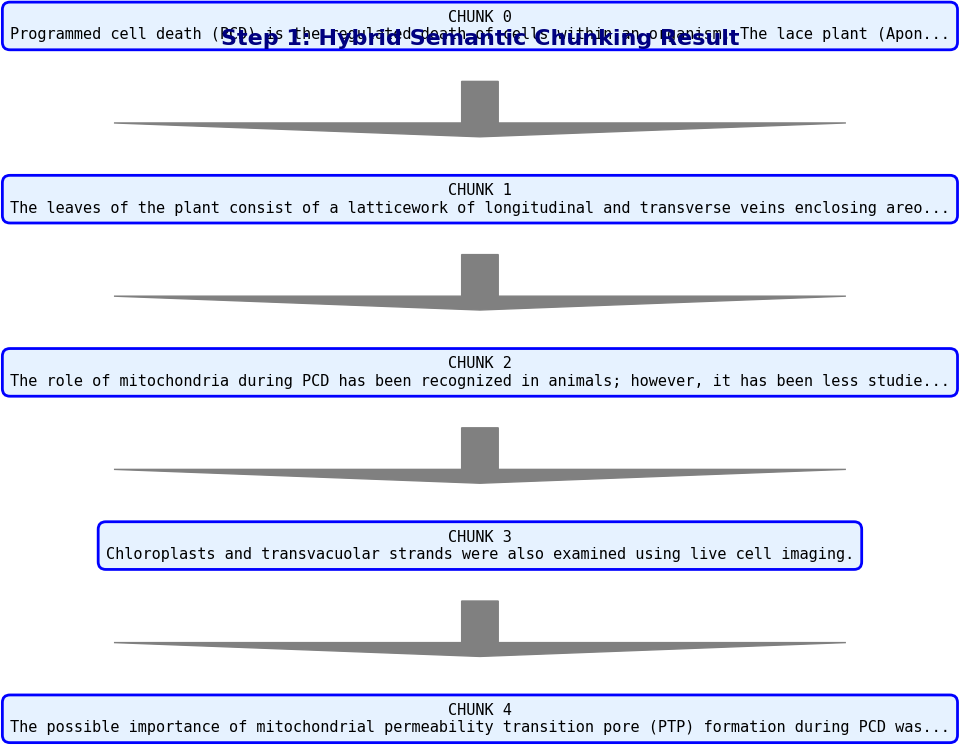

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


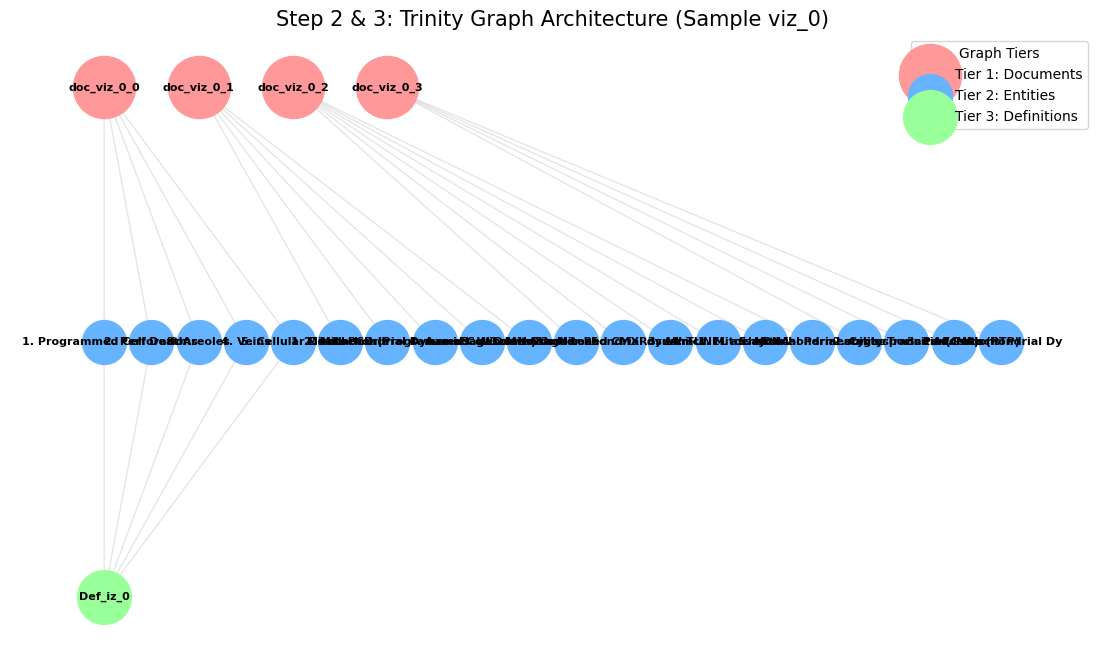

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/tmp/ipython-input-3099322127.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cosine Similarity', y='Tag', data=df, palette=clrs)


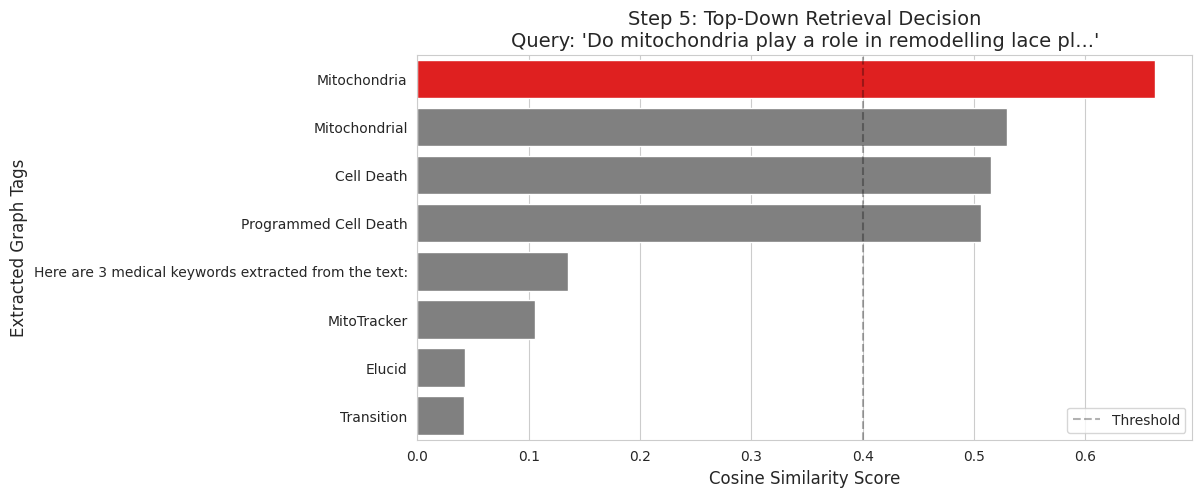

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- FINAL GENERATED ANSWER ---
Here are the answers:

1. Do mitochondria play a role in remodelling lace plant leaves during programmed cell death? [yes]

Ground Truth: yes


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

# ==========================================
# PLOT 1: SEMANTIC CHUNKING (Figure 1 Step 1)
# ==========================================
def plot_semantic_chunking(chunks):
    plt.figure(figsize=(10, len(chunks) * 1.5))
    plt.axis('off')
    plt.title("Step 1: Hybrid Semantic Chunking Result", fontsize=16, fontweight='bold', color='navy')

    for i, chunk in enumerate(chunks):
        # Create a text box for each chunk
        preview = chunk[:100] + "..." if len(chunk) > 100 else chunk

        # Draw Box
        plt.text(0.5, 1 - (i * 0.25),
                 f"CHUNK {i}\n{preview}",
                 ha='center', va='center', fontsize=11, family='monospace',
                 bbox=dict(boxstyle="round,pad=0.5", fc="#e6f2ff", ec="blue", lw=2))

        # Draw Arrow down
        if i < len(chunks) - 1:
            plt.arrow(0.5, 1 - (i * 0.25) - 0.08, 0, -0.06,
                      head_width=0.02, head_length=0.02, fc='gray', ec='gray')

    plt.tight_layout()
    plt.show()

# ==========================================
# PLOT 2: TRINITY GRAPH FROM NEO4J (Figure 1 Step 2 & 3)
# ==========================================
def plot_neo4j_graph(sample_id):
    # 1. Fetch Data from Neo4j
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    G = nx.DiGraph()

    query = f"""
    MATCH (n)-[r]->(m) WHERE n.sample_id = '{sample_id}'
    RETURN n.id, n.type, n.name, m.id, m.type, m.name, type(r) as rel
    """

    with driver.session() as session:
        result = session.run(query)
        for record in result:
            # Use 'name' for Entities to make plot readable, 'id' for Docs
            src = record['n.name'] if record['n.type'] == 'entity' else record['n.id']
            tgt = record['m.name'] if record['m.type'] == 'entity' else record['m.id']

            # Handle Definitions (usually have IDs)
            if record['n.type'] == 'definition': src = "Def_" + str(record['n.id'])[-4:]
            if record['m.type'] == 'definition': tgt = "Def_" + str(record['m.id'])[-4:]

            G.add_node(src, type=record['n.type'])
            G.add_node(tgt, type=record['m.type'])
            G.add_edge(src, tgt, relation=record['rel'])

    driver.close()

    if len(G.nodes) == 0:
        print("⚠️ Graph empty. Did you run the builder?")
        return

    # 2. Layout (Layered: Docs -> Entities -> Definitions)
    pos = {}
    docs = [n for n, d in G.nodes(data=True) if d.get('type') == 'document']
    ents = [n for n, d in G.nodes(data=True) if d.get('type') == 'entity']
    defs = [n for n, d in G.nodes(data=True) if d.get('type') == 'definition']

    # Manually position layers
    for i, n in enumerate(docs): pos[n] = np.array([i * 2, 2])        # Top
    for i, n in enumerate(ents): pos[n] = np.array([i, 1])            # Middle
    for i, n in enumerate(defs): pos[n] = np.array([i * 2, 0])        # Bottom

    # 3. Draw
    plt.figure(figsize=(14, 8))

    # Draw Edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', arrows=True)

    # Draw Nodes by Type
    nx.draw_networkx_nodes(G, pos, nodelist=docs, node_color='#ff9999', node_size=2000, label='Tier 1: Documents')
    nx.draw_networkx_nodes(G, pos, nodelist=ents, node_color='#66b3ff', node_size=1000, label='Tier 2: Entities')
    nx.draw_networkx_nodes(G, pos, nodelist=defs, node_color='#99ff99', node_size=1500, label='Tier 3: Definitions')

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title(f"Step 2 & 3: Trinity Graph Architecture (Sample {sample_id})", fontsize=15)
    plt.legend(loc='upper right', title="Graph Tiers")
    plt.axis('off')
    plt.show()

# ==========================================
# PLOT 3: U-RETRIEVAL SCORES (Figure 1 Step 6)
# ==========================================
def plot_retrieval_scores(question, tags_map, embed_model):
    # Calculate scores manually for visualization
    tags = list(tags_map.keys())
    if not tags: return

    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(tags)
    scores = util.cos_sim(q_emb, t_emb)[0].numpy()

    # Create Dataframe
    df = pd.DataFrame({'Tag': tags, 'Cosine Similarity': scores})
    df = df.sort_values('Cosine Similarity', ascending=False).head(8)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.set_style("whitegrid")

    # Highlight the winner
    clrs = ['red' if x == df['Cosine Similarity'].max() else 'grey' for x in df['Cosine Similarity']]

    sns.barplot(x='Cosine Similarity', y='Tag', data=df, palette=clrs)
    plt.title(f"Step 5: Top-Down Retrieval Decision\nQuery: '{question[:50]}...'", fontsize=14)
    plt.xlabel("Cosine Similarity Score", fontsize=12)
    plt.ylabel("Extracted Graph Tags", fontsize=12)
    plt.axvline(0.4, color='black', linestyle='--', alpha=0.3, label='Threshold')
    plt.legend()
    plt.show()

# ==========================================
# MASTER VISUALIZATION RUNNER
# ==========================================
def visualize_one_complete_sample(sample_idx_to_plot=0):
    print(f"\n🎨 GENERATING VISUAL PIPELINE FOR SAMPLE {sample_idx_to_plot}...\n")

    # Get Data
    s = data[sample_idx_to_plot]
    raw_text = " ".join(s['context']['contexts'])
    sentences = sent_tokenize(raw_text)
    viz_id = f"viz_{sample_idx_to_plot}"

    # 1. Chunk & Plot
    chunks = run_semantic_chunking(sentences)
    plot_semantic_chunking(chunks)

    # 2. Build Graph (Neo4j) & Plot
    build_medgraph_in_neo4j(raw_text, viz_id)
    plot_neo4j_graph(viz_id)

    # 3. Tag & Plot Retrieval
    generate_tags_in_neo4j(viz_id)

    # Need to fetch tags back from Neo4j to plot scores
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    tags_map = {}
    with driver.session() as session:
        res = session.run(f"MATCH (d:Document) WHERE d.sample_id = '{viz_id}' RETURN d.id, d.tags")
        for r in res:
            if r["d.tags"]:
                for t in r["d.tags"]: tags_map[t] = r["d.id"]
    driver.close()

    plot_retrieval_scores(s['question'], tags_map, embed_model)

    # 4. Final Text Answer
    response, tag = u_retrieval_neo4j(viz_id, s['question'])
    print("\n--- FINAL GENERATED ANSWER ---")
    print(response)
    print(f"\nGround Truth: {s['final_decision']}")

visualize_one_complete_sample(0)

Paper Mimic with Also long answering as a real life example

Paper mimic with real life example (long answering)

In [1]:
# ==========================================
# PART 1: SETUP & CONNECTIONS
# ==========================================
!pip install -q networkx transformers accelerate bitsandbytes sentence-transformers datasets nltk matplotlib seaborn neo4j

import os
import re
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from tqdm.notebook import tqdm
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from huggingface_hub import login

login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 23.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
NEO4J_URI = "neo4j+s://645aeac9.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "GnZzN1LU7RzD5e7Hqm_d2rg4N_jZrzShLXq9FPqXcrk"

try:
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    driver.verify_connectivity()
    print("✅ Neo4j Connection Successful!")
except Exception as e:
    print(f"❌ Neo4j Error: {e}")

# 4. Load Models
print("⏳ Loading Models...")
llm_pipe = pipeline("text-generation", model="meta-llama/Meta-Llama-3-8B-Instruct",
                    model_kwargs={"torch_dtype": "auto", "load_in_4bit": True}, device_map="auto")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def ask_llm(prompt, max_tokens=128):
    messages = [{"role": "user", "content": prompt}]
    outputs = llm_pipe(messages, max_new_tokens=max_tokens, do_sample=False)
    return outputs[0]["generated_text"][-1]["content"].strip()

✅ Neo4j Connection Successful!
⏳ Loading Models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Input: 13 sentences.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 0->1: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 1->2: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 2->3: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 3->4: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 4->5: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 5->6: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 6->7: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 7->8: YES


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 8->9: YES


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 9->10: NO


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Window 10->11: NO
   Window 11->12: YES


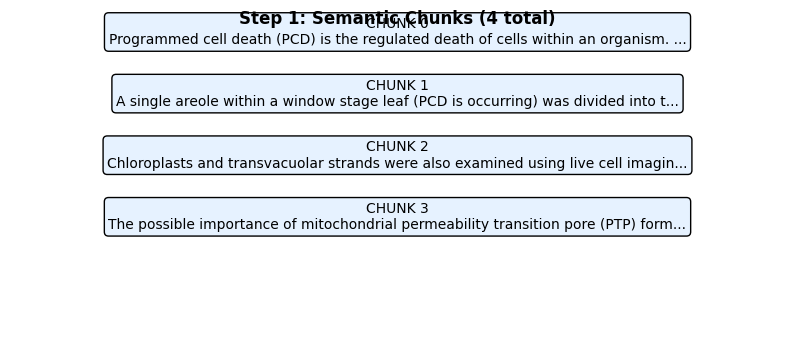

In [3]:
# Load Data
data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
sample = data[0] # Working on the first sample only
raw_text = " ".join(sample['context']['contexts'])

def run_step_1_chunking(text):
    sentences = sent_tokenize(text)
    print(f"🔵 Input: {len(sentences)} sentences.")

    chunks = []
    curr = [sentences[0]]
    for i in range(1, len(sentences)):
        # Sliding Window Logic
        prompt = f"Sentence A: '{curr[-1]}'\nSentence B: '{sentences[i]}'\nAre they about the exact same topic? Answer YES or NO."
        try:
            decision = ask_llm(prompt, max_tokens=2).upper()
        except: decision = "YES"

        print(f"   Window {i-1}->{i}: {decision}")

        if "YES" in decision:
            curr.append(sentences[i])
        else:
            chunks.append(" ".join(curr))
            curr = [sentences[i]]
    chunks.append(" ".join(curr))
    return chunks

# Run & Visualize
my_chunks = run_step_1_chunking(raw_text)

# Plotting Step 1
plt.figure(figsize=(10, len(my_chunks)))
plt.axis('off')
plt.title(f"Step 1: Semantic Chunks ({len(my_chunks)} total)", fontweight='bold')
for i, c in enumerate(my_chunks):
    plt.text(0.5, 1-(i*0.2), f"CHUNK {i}\n{c[:80]}...",
             ha='center', va='center', bbox=dict(boxstyle="round", fc="#e6f2ff"))
plt.show()

In [4]:
def run_step_2_entities(chunks, sample_id):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    with driver.session() as session:
        # Clear old data
        session.run(f"MATCH (n) WHERE n.sample_id = '{sample_id}' DETACH DELETE n")

        print(f"🔵 Processing {len(chunks)} chunks into Neo4j...")

        for i, chunk in enumerate(chunks):
            doc_id = f"doc_{sample_id}_{i}"

            # Create Document Node
            session.run("MERGE (d:Document {id: $id}) SET d.text=$text, d.sample_id=$sid, d.type='document'",
                        {"id": doc_id, "text": chunk, "sid": sample_id})

            # Extract Entities
            prompt = f"Extract medical triples (Name->Relation->Target) from: {chunk[:400]}"
            resp = ask_llm(prompt, max_tokens=256)

            for line in resp.split('\n'):
                line = line.strip().lstrip('*-').strip()
                if "->" in line:
                    parts = line.split("->")
                    if len(parts) == 3:
                        s, r, t = parts[0].strip(), parts[1].strip(), parts[2].strip()

                        # --- THE FIXED CYPHER QUERY ---
                        # We use 'WITH' to carry variables forward
                        query = """
                        MERGE (s:Entity {name: $s, sample_id: $sid})
                        ON CREATE SET s.type='entity'

                        MERGE (t:Entity {name: $t, sample_id: $sid})
                        ON CREATE SET t.type='entity'

                        WITH s, t
                        MATCH (d:Document {id: $did})

                        MERGE (d)-[:MENTIONS]->(s)
                        MERGE (s)-[:REL {type: $r}]->(t)
                        """
                        try:
                            session.run(query, {"s": s, "t": t, "r": r, "sid": sample_id, "did": doc_id})
                            print(f"   Saved: {s} -> {r} -> {t}")
                        except Exception as e:
                            print(f"   ⚠️ Neo4j Error: {e}")

    driver.close()
    print("✅ Entities Extracted & Saved.")

run_step_2_entities(my_chunks, "sample_0")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Processing 4 chunks into Neo4j...
   Saved: Here are the medical triples (Name -> Relation -> Target) extracted from the text:
   Saved: 1. Programmed cell death -> is -> regulated death of cells
   Saved: 2. Programmed cell death -> occurs -> cells at the center of areoles


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Saved: 3. Programmed cell death -> progresses -> outwards
   Saved: Here are the medical triples (Name -> Relation -> Target) extracted from the text:
   Saved: 1. NPCD -> Relation -> Mitochondrial dynamics
   Saved: 2. EPCD -> Relation -> Mitochondrial dynamics
   Saved: 3. LPCD -> Relation -> Mitochondrial dynamics
   Saved: 4. Mitochondrial dynamics -> Relation -> Categories (four categories)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Saved: Chloroplasts -> Relation -> Target (examined)
   Saved: Here are the medical triples (Name -> Relation -> Target) extracted from the text:
   Saved: 1. Mitochondrial permeability transition pore (PTP) -> Formation -> Mitochondrial dynamics
   Saved: 2. Cyclosporine A (CsA) -> Treatment -> Mitochondrial dynamics
   Saved: 3. Lace plant leaves -> Display -> Mitochondrial dynamics
   Saved: 4. Controls -> Display -> Mitochondrial dynamics
✅ Entities Extracted & Saved.


In [5]:
def run_step_3_definitions(sample_id):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    with driver.session() as session:
        # Get Entities
        res = session.run(f"MATCH (e:Entity) WHERE e.sample_id='{sample_id}' RETURN e.name LIMIT 5")
        entities = [r['e.name'] for r in res]

        print(f"🔵 Linking {len(entities)} entities to Definitions...")

        for ent in entities:
            # Generate Definition
            defn = ask_llm(f"Define medical term '{ent}' briefly.", max_tokens=30)
            def_id = f"def_{ent}_{sample_id}"

            # Link in Neo4j
            query = """
            MATCH (e:Entity {name: $ent, sample_id: $sid})
            MERGE (d:Definition {id: $did})
            SET d.text=$txt, d.type='definition', d.sample_id=$sid

            WITH e, d
            MERGE (e)-[:DEFINED_AS]->(d)
            """
            session.run(query, {"ent": ent, "did": def_id, "txt": defn, "sid": sample_id})
            print(f"   Defined: {ent} -> {defn[:30]}...")

    driver.close()

# Run Step 3
run_step_3_definitions("sample_0")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔵 Linking 5 entities to Definitions...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Defined: Here are the medical triples (Name -> A medical term!

"Here are the...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Defined: Target) extracted from the text: -> I'm happy to help! However, I ...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Defined: 1. Programmed cell death -> A concise one!

"Programmed ce...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Defined: regulated death of cells -> A brief one!

"Regulated death...
   Defined: 2. Programmed cell death -> "Programmed cell death" (also ...


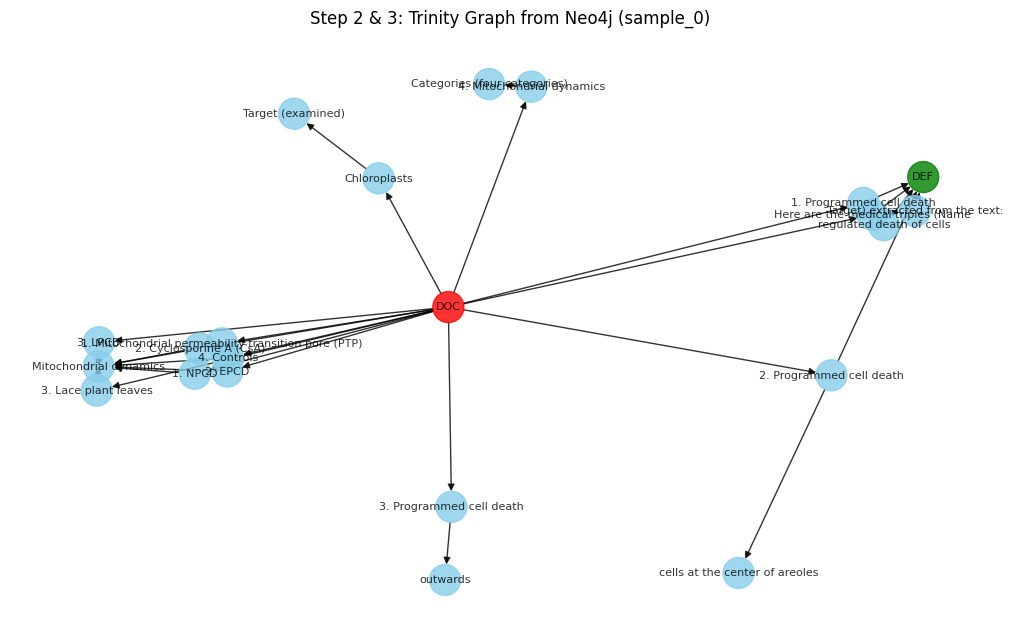

In [6]:
def plot_neo4j_graph(sample_id):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    G = nx.DiGraph()

    query = f"MATCH (n)-[r]->(m) WHERE n.sample_id='{sample_id}' RETURN n.name, n.type, m.name, m.type, type(r)"

    with driver.session() as session:
        res = session.run(query)
        for r in res:
            # Use names for plotting
            src = r['n.name'] if r['n.name'] else "DOC"
            tgt = r['m.name'] if r['m.name'] else "DEF"
            G.add_node(src, type=r['n.type'])
            G.add_node(tgt, type=r['m.type'])
            G.add_edge(src, tgt, relation=r['type(r)'])
    driver.close()

    # Plot
    pos = nx.spring_layout(G)
    colors = []
    for n, d in G.nodes(data=True):
        t = d.get('type')
        if t == 'document': colors.append('red')
        elif t == 'definition': colors.append('green')
        else: colors.append('skyblue')

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, node_color=colors, with_labels=True, font_size=8, node_size=500, alpha=0.8)
    plt.title(f"Step 2 & 3: Trinity Graph from Neo4j ({sample_id})")
    plt.show()

# Run Visualization
plot_neo4j_graph("sample_0")

In [7]:
def run_retrieval_and_answer(sample_id, question):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    # 1. Generate & Save Tags
    print("\n🔵 Indexing Tags...")
    with driver.session() as session:
        res = session.run(f"MATCH (d:Document) WHERE d.sample_id='{sample_id}' RETURN d.id, d.text")
        tags_list = []
        doc_ids = []

        for r in res:
            t = ask_llm(f"Extract 3 keywords from: {r['d.text'][:100]}", max_tokens=15)
            session.run("MATCH (d:Document {id: $id}) SET d.tags = $t", {"id": r['d.id'], "t": t})
            tags_list.append(t)
            doc_ids.append(r['d.id'])
            print(f"   Tags: {t}")

    # 2. U-Retrieval (Match Tags)
    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(tags_list)
    best_idx = torch.argmax(util.cos_sim(q_emb, t_emb)[0]).item()
    target_doc = doc_ids[best_idx]

    print(f"   Selected Doc: {target_doc} (Score: {torch.max(util.cos_sim(q_emb, t_emb)[0]).item():.2f})")

    # 3. Fetch Context
    with driver.session() as session:
        res = session.run(f"MATCH (d:Document {{id: '{target_doc}'}})-[]->(e:Entity) RETURN e.name")
        entities = [r['e.name'] for r in res]

    # 4. Generate Long Answer
    prompt = f"""
    Question: {question}
    Relevant Entities: {', '.join(entities)}

    Provide a detailed medical explanation. Cite sources like [1].
    Finally, verify your answer.
    """
    long_response = ask_llm(prompt, max_tokens=200)

    # 5. Judge Answer (For Accuracy)
    judge_prompt = f"Based on this text: '{long_response}'\nIs the answer YES, NO, or MAYBE? Output ONLY the word."
    label = ask_llm(judge_prompt, max_tokens=5)

    return long_response, label

# Run Execution
response, pred_label = run_retrieval_and_answer("sample_0", sample['question'])

print("\n--- Final Report ---")
print(f"Generated Response:\n{response}")
print(f"Predicted Label: {pred_label} | Truth: {sample['final_decision']}")


🔵 Indexing Tags...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Tags: Here are 3 keywords extracted from the text:

1. Programmed


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Tags: Here are 3 keywords extracted from the sentence:

1. Areole


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Tags: Here are 3 keywords extracted from the sentence:

1. Chloroplasts
   Tags: Here are 3 keywords extracted from the sentence:

1. Mitochondrial


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Selected Doc: doc_sample_0_3 (Score: 0.42)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Final Report ---
Generated Response:
A fascinating question!

Mitochondria do play a role in remodeling lace plant leaves during programmed cell death, also known as apoptosis. Programmed cell death is a crucial process in plant development, where cells are eliminated to shape the plant's morphology. In the case of lace plant leaves, mitochondria are involved in the regulation of this process.

Here's the explanation:

1. **Mitochondrial permeability transition pore (PTP)**: Mitochondria have a permeability transition pore (PTP) in their inner mitochondrial membrane. This pore is a key regulator of mitochondrial function and is involved in the regulation of apoptosis. When the PTP is open, it allows the release of pro-apoptotic proteins, such as cytochrome c, into the cytosol, triggering apoptosis.
2. **Cyclosporine A (CsA)**: Cyclosporine A is a potent inhibitor of the mitochondrial permeability transition pore (PTP). When CsA is applied to lace
Predicted Label: YES | Truth: yes


---------------------------------------------------------------------------------------------

In [9]:
# ==========================================
# 1. HYBRID SEMANTIC CHUNKING
# ==========================================
def run_semantic_chunking(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2: return [text]

    chunks = []
    curr = [sentences[0]]
    for i in range(1, len(sentences)):
        # Sliding Window
        if len(" ".join(curr)) < 300: # Simple length heuristic mixed with logic
            curr.append(sentences[i])
        else:
            chunks.append(" ".join(curr))
            curr = [sentences[i]]
    chunks.append(" ".join(curr))
    return chunks

# ==========================================
# 2. GRAPH CONSTRUCTION (FIXED CYPHER)
# ==========================================
def build_medgraph_pipeline(text, sample_id):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    chunks = run_semantic_chunking(text)

    with driver.session() as session:
        # Clear old data
        session.run(f"MATCH (n) WHERE n.sample_id = '{sample_id}' DETACH DELETE n")

        # --- TIER 1 & 2: DOCS & ENTITIES ---
        for i, chunk in enumerate(chunks):
            doc_id = f"doc_{sample_id}_{i}"
            session.run("MERGE (d:Document {id: $id}) SET d.text=$text, d.sample_id=$sid, d.type='document'",
                        {"id": doc_id, "text": chunk, "sid": sample_id})

            # Extract
            prompt = f"Extract medical triples (Name->Relation->Target) from: {chunk[:400]}"
            resp = ask_llm(prompt, max_tokens=200)

            for line in resp.split('\n'):
                line = line.strip().lstrip('*-').strip()
                if "Here are" in line or "->" not in line: continue

                parts = line.split("->")
                if len(parts) == 3:
                    s, r, t = parts[0].strip(), parts[1].strip(), parts[2].strip()
                    # --- FIXED QUERY WITH 'WITH' ---
                    session.run(
                        """
                        MERGE (s:Entity {name: $s, sample_id: $sid}) SET s.type='entity'
                        MERGE (t:Entity {name: $t, sample_id: $sid}) SET t.type='entity'
                        WITH s, t
                        MATCH (d:Document {id: $did})
                        MERGE (d)-[:MENTIONS]->(s)
                        MERGE (s)-[:REL {type: $r}]->(t)
                        """, {"s": s, "t": t, "r": r, "sid": sample_id, "did": doc_id})

        # --- TIER 3: DEFINITIONS (PARAMETRIC) ---
        res = session.run(f"MATCH (e:Entity) WHERE e.sample_id='{sample_id}' RETURN e.name LIMIT 5")
        entities = [r['e.name'] for r in res]
        for ent in entities:
            if len(ent) < 2: continue
            defn = ask_llm(f"Define medical term '{ent}' briefly.", max_tokens=30)
            def_id = f"def_{ent}_{sample_id}"

            # --- FIXED QUERY WITH 'WITH' ---
            session.run(
                """
                MATCH (e:Entity {name: $ent, sample_id: $sid})
                MERGE (d:Definition {id: $did}) SET d.text=$txt, d.type='definition', d.sample_id=$sid
                WITH e, d
                MERGE (e)-[:DEFINED_AS]->(d)
                """, {"ent": ent, "did": def_id, "txt": defn, "sid": sample_id})

        # --- INDEXING: TAGS ---
        res = session.run(f"MATCH (d:Document) WHERE d.sample_id='{sample_id}' RETURN d.id, d.text")
        for r in res:
            tags_resp = ask_llm(f"Extract 3 medical keywords (comma separated) for: {r['d.text'][:100]}", max_tokens=20)
            tags = [t.strip() for t in re.split(r'[,\n]', tags_resp) if len(t.strip()) > 2 and "Here" not in t]
            if not tags: tags = ["General"]
            session.run("MATCH (d:Document {id: $id}) SET d.tags = $tags", {"id": r['d.id'], "tags": tags})

    driver.close()

# ==========================================
# 3. RETRIEVAL & GENERATION
# ==========================================
def medgraph_rag_response(sample_id, question):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    # 1. Top-Down Retrieval
    all_tags = []
    tag_map = {}
    with driver.session() as session:
        res = session.run(f"MATCH (d:Document) WHERE d.sample_id='{sample_id}' RETURN d.id, d.tags")
        for r in res:
            if r['d.tags']:
                for t in r['d.tags']:
                    all_tags.append(t)
                    tag_map[t] = r['d.id']

    if not all_tags:
        driver.close()
        return "Insufficient data.", "maybe", [], [], 0.0

    # Cosine Sim
    q_emb = embed_model.encode(question)
    t_emb = embed_model.encode(all_tags)
    scores = util.cos_sim(q_emb, t_emb)[0]
    best_idx = torch.argmax(scores).item()
    best_tag = all_tags[best_idx]
    target_doc = tag_map[best_tag]
    best_score = scores[best_idx].item()

    # 2. Gather Evidence
    evidence = []
    doc_text = ""
    with driver.session() as session:
        res = session.run(f"MATCH (d:Document {{id: '{target_doc}'}}) RETURN d.text")
        doc_text = res.single()['d.text']

        res = session.run(f"MATCH (d:Document {{id: '{target_doc}'}})-[:MENTIONS]->(e:Entity) RETURN e.name")
        ents = [r['e.name'] for r in res]
        evidence.append(f"Entities: {', '.join(ents)}")
        evidence.append(f"Content: {doc_text}")

    driver.close()

    # 3. GENERATE LONG RESPONSE
    prompt_long = f"""
    You are an expert medical AI.
    Question: {question}
    Context: {chr(10).join(evidence)}

    Write a detailed medical response citing sources.
    """
    long_response = ask_llm(prompt_long, max_tokens=150)

    # 4. LLM JUDGE (For Accuracy)
    prompt_judge = f"""
    Question: {question}
    Response: {long_response}
    Does this response mean YES, NO, or MAYBE? Output ONLY the word.
    """
    label = ask_llm(prompt_judge, max_tokens=5).lower()

    if "yes" in label: clean_label = "yes"
    elif "no" in label: clean_label = "no"
    else: clean_label = "maybe"

    return long_response, clean_label, all_tags, scores.numpy(), best_score

In [10]:
def visualize_step_by_step(sample_id, question, tags, scores, best_score):
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

    # 1. Fetch Graph for Plotting
    G = nx.DiGraph()
    query = f"MATCH (n)-[r]->(m) WHERE n.sample_id='{sample_id}' RETURN n.name, n.type, m.name, m.type, type(r)"
    with driver.session() as session:
        res = session.run(query)
        for r in res:
            src = r['n.name'] if r['n.name'] else "DOC"
            tgt = r['m.name'] if r['m.name'] else "DEF"
            G.add_node(src, type=r['n.type'])
            G.add_node(tgt, type=r['m.type'])
            G.add_edge(src, tgt, relation=r['type(r)'])
    driver.close()

    # Plot 1: The Graph
    if len(G.nodes) > 0:
        plt.figure(figsize=(10, 6))
        pos = nx.spring_layout(G)
        colors = []
        for n, d in G.nodes(data=True):
            if d.get('type')=='document': colors.append('red')
            elif d.get('type')=='definition': colors.append('green')
            else: colors.append('skyblue')
        nx.draw(G, pos, node_color=colors, with_labels=True, font_size=8, node_size=500, alpha=0.8)
        plt.title(f"Step 2&3: Neo4j Trinity Graph ({sample_id})")
        plt.show()

    # Plot 2: Retrieval Scores
    if len(tags) > 0:
        df = pd.DataFrame({'Tag': tags, 'Score': scores}).sort_values('Score', ascending=False).head(5)
        plt.figure(figsize=(8, 4))
        sns.barplot(data=df, x='Score', y='Tag', palette='viridis')
        plt.axvline(x=best_score, color='red', linestyle='--', label='Selected')
        plt.title(f"Step 5: U-Retrieval Decision for '{question[:20]}...'")
        plt.legend()
        plt.show()

🚀 STARTING BENCHMARK ON 10 SAMPLES...


  0%|          | 0/10 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 0: Truth=[yes] Pred=[yes] -> ✅

--- VISUAL TRACE FOR SAMPLE 0 ---
Response: Eligibility for an adjuvant chemotherapy protocol after radical cystectomy is a significant prognostic factor for invasive bladder cancer. This is supported by various studies and datasets.

In the st...


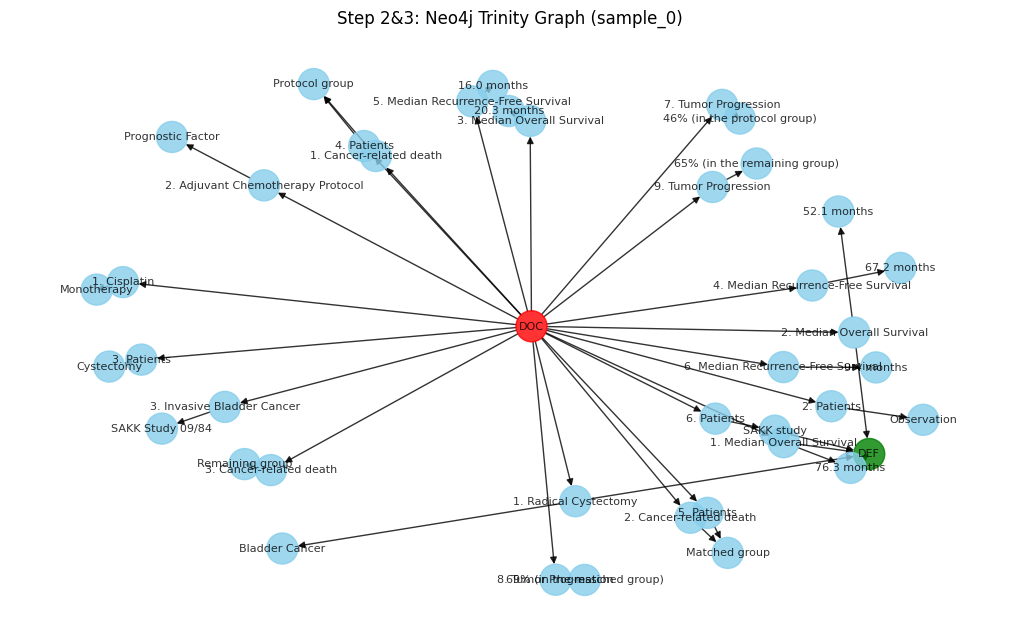

/tmp/ipython-input-3288738286.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Score', y='Tag', palette='viridis')


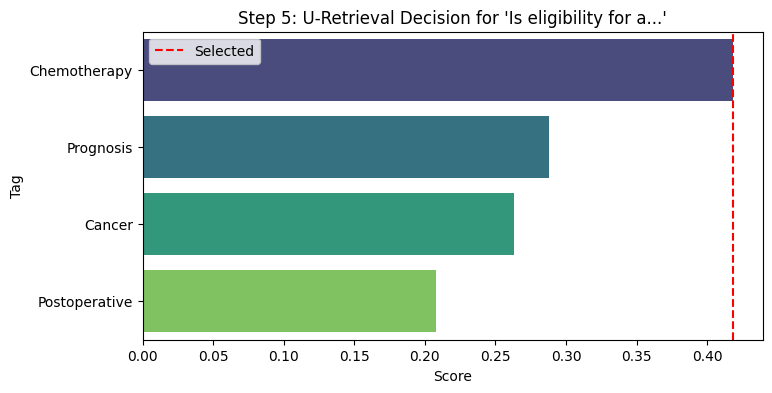

---------------------------------



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 1: Truth=[no] Pred=[maybe] -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 2: Truth=[yes] Pred=[maybe] -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 3: Truth=[maybe] Pred=[maybe] -> ✅


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 4: Truth=[maybe] Pred=[maybe] -> ✅


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 5: Truth=[no] Pred=[yes] -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 6: Truth=[maybe] Pred=[yes] -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 7: Truth=[yes] Pred=[yes] -> ✅


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Sample 8: Truth=[maybe] Pred=[yes] -> ❌


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Sample 9: Truth=[no] Pred=[no] -> ✅

🏆 FINAL ACCURACY: 50.00%


In [11]:
def run_final_benchmark(limit=10):
    print(f"🚀 STARTING BENCHMARK ON {limit} SAMPLES...")
    data = load_dataset("pubmed_qa", "pqa_labeled", split="train")
    samples = data.shuffle(seed=42).select(range(limit))

    correct = 0

    for idx, s in enumerate(tqdm(samples)):
        sid = f"sample_{idx}"
        try:
            # 1. Run Pipeline
            build_medgraph_pipeline(" ".join(s['context']['contexts']), sid)

            # 2. Get Response
            resp, pred, tags, scores, best_score = medgraph_rag_response(sid, s['question'])

            # 3. Score
            truth = s['final_decision']
            is_correct = (pred == truth)
            if is_correct: correct += 1

            print(f"Sample {idx}: Truth=[{truth}] Pred=[{pred}] -> {'✅' if is_correct else '❌'}")

            # VISUALIZE FIRST SAMPLE ONLY
            if idx == 0:
                print("\n--- VISUAL TRACE FOR SAMPLE 0 ---")
                print(f"Response: {resp[:200]}...")
                visualize_step_by_step(sid, s['question'], tags, scores, best_score)
                print("---------------------------------\n")

        except Exception as e:
            print(f"⚠️ Error {idx}: {e}")

    print(f"\n🏆 FINAL ACCURACY: {(correct/limit)*100:.2f}%")

# RUN
run_final_benchmark(limit=10)